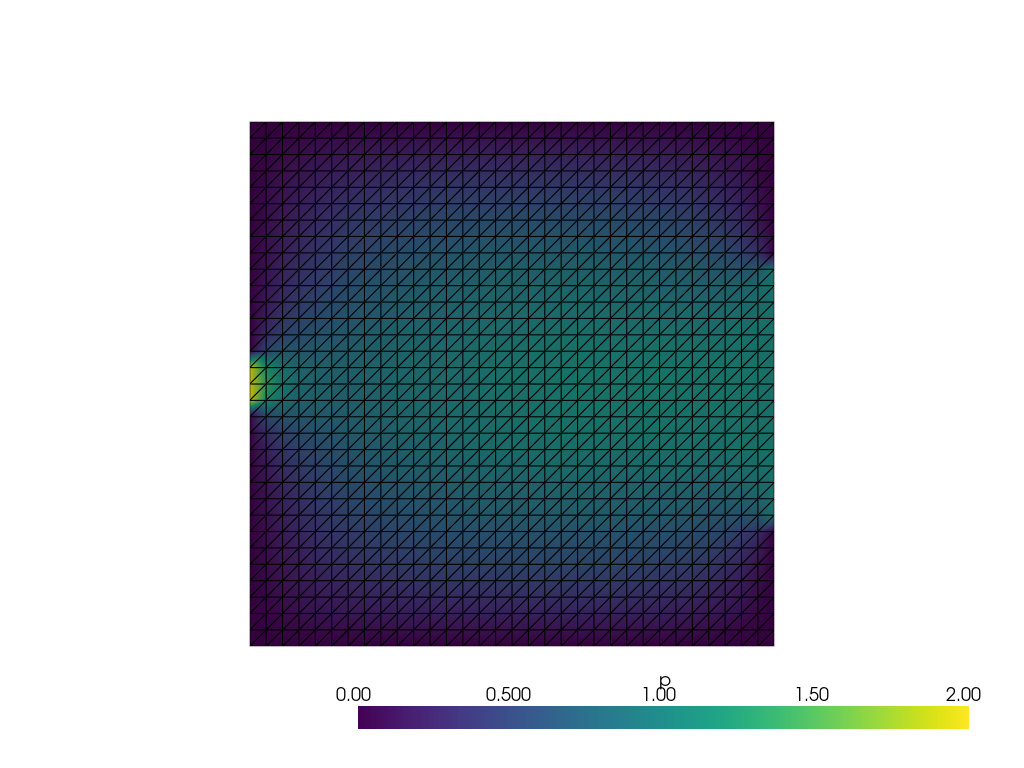

In [94]:
import numpy as np
from mpi4py import MPI
from dolfinx import mesh, fem, plot
from petsc4py import PETSc
from dolfinx.fem import locate_dofs_geometrical
from dolfinx.fem.petsc import LinearProblem
import ufl
import pyvista
from dolfinx.plot import vtk_mesh


# Create a mesh (unit square in this example)
domain = mesh.create_unit_square(MPI.COMM_WORLD, 32, 32)

# Define function space for pressure
V = fem.functionspace(domain, ("Lagrange", 1))

def is_limit(x):
    return np.isclose(x[0], 0.0) | np.isclose(x[0], 1.0) | np.isclose(x[1], 0.0) | np.isclose(x[1], 1.0)

# Define boundary condition
def boundary_walls(x):
    return (
        (np.isclose(x[0], 0.0) & ((x[1] < 0.45) | (0.55 < x[1])))
        | (np.isclose(x[0], 1.0) & ((x[1] < 0.25) | (0.75 < x[1])))
        | np.isclose(x[1], 0.0)
        | np.isclose(x[1], 1.0)
    ) & is_limit(x)

def boundary_open(x):
    return (
        ~boundary_walls(x)
        & is_limit(x)
    )

def is_left_wall(x):
    return np.isclose(x[0], 0)

def is_right_wall(x):
    return np.isclose(x[0], 1)

bc_wall = fem.dirichletbc(fem.Constant(domain, PETSc.ScalarType(0)), locate_dofs_geometrical(V, boundary_walls), V)
bc_left_open = fem.dirichletbc(fem.Constant(domain, PETSc.ScalarType(2)), locate_dofs_geometrical(V, lambda x: boundary_open(x) & is_left_wall(x)), V)
bc_right_open = fem.dirichletbc(fem.Constant(domain, PETSc.ScalarType(1)), locate_dofs_geometrical(V, lambda x: boundary_open(x) & is_right_wall(x)), V)

# Define trial and test functions
p = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define the permeability, viscosity and source term
k = fem.Constant(domain, PETSc.ScalarType(1))  # Permeability
mu = fem.Constant(domain, PETSc.ScalarType(10))  # Viscosity
f = fem.Constant(domain, PETSc.ScalarType(1))  # Source term

# Define the variational form
a_p = (k / mu) * ufl.dot(ufl.grad(p), ufl.grad(v)) * ufl.dx
L_p = f * v * ufl.dx

problem = LinearProblem(a_p, L_p, bcs=[bc_wall, bc_left_open, bc_right_open], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
ph = problem.solve()

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["p"] = ph.x.array.real
u_grid.set_active_scalars("p")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()

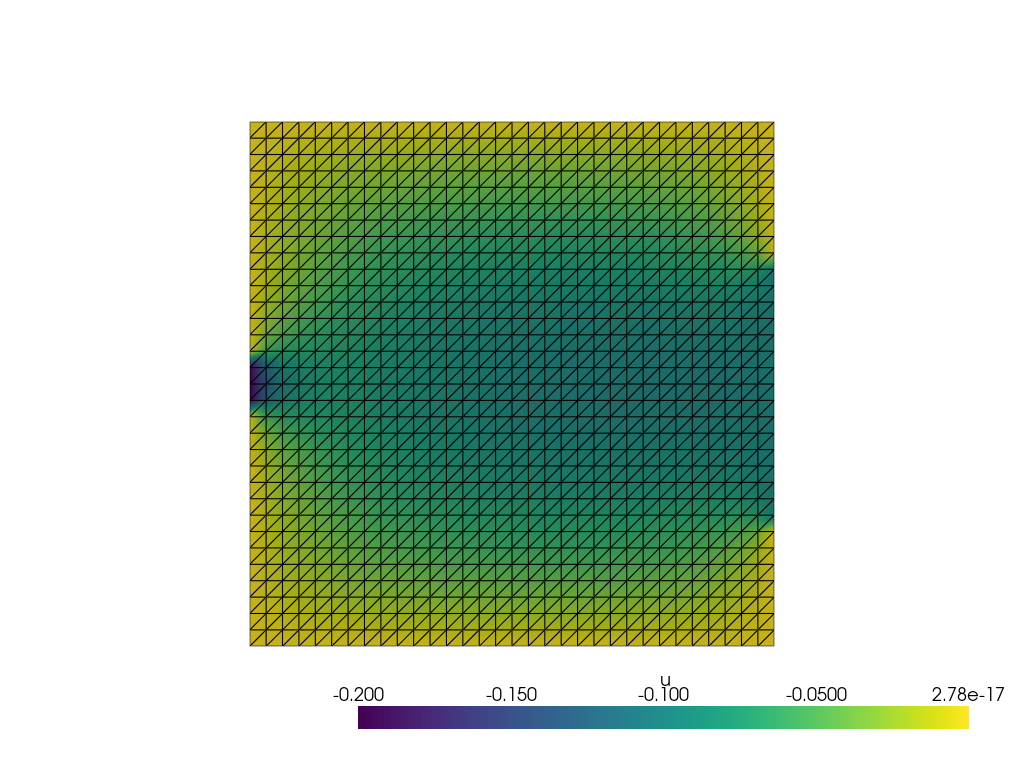

In [95]:
u = ufl.TrialFunction(V)
a_u =  ufl.dot(u, v) * ufl.dx
L_u = -(k / mu) * ph * v * ufl.dx

problem = LinearProblem(a_u, L_u, petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()